# Hopfield Network Upgraded
This is an upgrade of the Hopfield Network created by the MRP: no more neurons limit + addition of some usefum statistics in the results.


In [1]:
# Hopfield v2 -> all even modules
############################### DEPENDENCIES ##################################
import json
import os
import sys
import contextlib
import io
import numpy as np
import inspect
import os.path
import matplotlib.pyplot as plt
from math import pi, atan, sin, cos, sqrt, tanh, cosh, exp, ceil
import seaborn as sns
from numpy.core.fromnumeric import shape
import random
import time
import math
from pathlib import Path


In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

print(module_path)

project_root = module_path

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub


In [3]:

from event_model import event_model as em
from validator import validator_lite as vl
import data_analysis.event_generator as eg
from visual.color_map import Colormap



In [4]:
########################### CONTEXTS ##################################
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout


In [5]:
########################### HELPER FUNCTIONS ##################################
def get_polar_coordinates(x, y):
    r = math.sqrt(x ** 2 + y ** 2)
    phi = math.atan2(x, y)
    if phi < 0:
        phi = math.pi - phi
    return r, phi


In [6]:
############################### BODY ##########################################
class Hopfield:
    def __init__(self, modules: list, parameters: dict, tracks: list = None):
        # set self variables, such as the maximum size
        self.p = parameters
        self.m = modules
        self.start_T = self.p["T"]
        self.start_B = self.p["B"]
        self.N = None
        self.N_info = None
        self.modules_count = len(modules)
        self.hit_counts = [len(module.hits()) for module in self.m]
        self.neuron_count = [
            self.hit_counts[i] * self.hit_counts[i + 1]
            for i in range(self.modules_count - 1)
        ]
        self.flips = 0
        self.max_neurons = max(self.neuron_count)
        self.init_neurons(tracks=tracks)
        self.init_weights()
        self.extracted_hits = set()
        self.extracted_tracks = []
        self.extracted_track_states = []
        self.energies = []

    def init_neurons(self, tracks: list = None):
        # consider hits in 2 modules as one neuron layer
        # the neurons in N are ordered h(1,1)-h(2,1); h(1,1)-h(2,2); h(1,1)-h(2,3) etc
        if self.p["random_neuron_init"]:
            self.N = np.random.uniform(size=(self.modules_count - 1, self.max_neurons))
        else:
            self.N = np.ones(shape=(self.modules_count - 1, self.max_neurons))
        if tracks:
            self.N = np.zeros(shape=(self.modules_count - 1, self.max_neurons))
        for idx, nc in enumerate(self.neuron_count):
            self.N[idx, nc:] = 0
        self.N_info = np.zeros(shape=(self.modules_count - 1, self.max_neurons, 4))
        for idx in range(self.modules_count - 1):
            m1 = self.m[idx]
            m2 = self.m[idx + 1]

            for i, hit1 in enumerate(m1.hits()):
                for j, hit2 in enumerate(m2.hits()):
                    n_idx = i * self.hit_counts[idx + 1] + j
                    if tracks:
                        for t in tracks:
                            if hit1 in t and hit2 in t:
                                self.N[idx, n_idx] = 1
                    # maybe we can check these angles again
                    angle_xz = atan((hit2.x - hit1.x) / (hit2.z - hit1.z))
                    angle_yz = atan((hit2.y - hit1.y) / (hit2.z - hit1.z))
                    norm_dist = sqrt(
                        (hit2.y - hit1.y) ** 2 + (hit2.x - hit1.x) ** 2
                    ) / sqrt(
                        (hit2.z - hit1.z) ** 2
                    )  
                
                    _, r_hit1 = get_polar_coordinates(hit1.x, hit1.y)
                    _, r_hit2 = get_polar_coordinates(hit2.x, hit2.y)
                    monotone_dist = (r_hit2 - r_hit1) / (hit2.z - hit1.z)

                    self.N_info[idx, n_idx, 0] = abs(angle_xz)
                    self.N_info[idx, n_idx, 1] = abs(angle_yz)
                    self.N_info[idx, n_idx, 2] = norm_dist  
                    self.N_info[idx, n_idx, 3] = monotone_dist

    def init_weights(self, neg_weights=False):
        #### get params from the dict #######
        alpha = self.p["ALPHA"]
        beta = self.p["BETA"]
        gamma = self.p["GAMMA"]
        #####################################
        self.W = np.zeros(
            shape=(self.modules_count - 2, self.max_neurons, self.max_neurons,)
        )

        # loops neuron_layer - neuron_layer weight matrices
        for w_idx in range(self.modules_count - 2):
            # loops hits of the module connecting the neuron layers
            for con_idx in range(self.hit_counts[w_idx + 1]):  # m2
                for i in range(self.hit_counts[w_idx]):  # m1
                    ln_idx = i * self.hit_counts[w_idx + 1] + con_idx  # left_neuron_idx
                    for j in range(self.hit_counts[w_idx + 2]):  # m3
                        rn_idx = (
                            con_idx * self.hit_counts[w_idx + 2] + j
                        )  # right_neuron_idx

                        # Constant term from the other group
                        constant = (
                            self.N_info[w_idx, ln_idx, 2]
                            - self.N_info[w_idx + 1, rn_idx, 2]
                        )
                        constant = tanh(constant) * (
                            self.p["narrowness"] + 1
                        )  # tanh to force between -1 and 1
                        constant = (
                            -2 * constant ** 2
                        ) + 1  # this should be high if both terms are similar and low/penalizing if both are not similar
                        constant = constant * self.p["constant_factor"]
                        constant = min(
                            max(constant, -self.p["constant_factor"]),
                            self.p["constant_factor"],
                        )

                        # monotone constant
                        monotone_constant = (
                            self.N_info[w_idx, ln_idx, 3]
                            - self.N_info[w_idx + 1, rn_idx, 3]
                        )
                        monotone_constant = tanh(monotone_constant) * (
                            self.p["narrowness"] + 1
                        )  # tanh to force between -1 and 1

                        monotone_constant = (
                            -2 * monotone_constant ** 2
                        ) + 1  # this should be high if both terms are similar and low/penalizing if both are not similar

                        monotone_constant = (
                            monotone_constant * self.p["monotone_constant_factor"]
                        )
                        monotone_constant = min(
                            max(monotone_constant, -self.p["monotone_constant_factor"]),
                            self.p["monotone_constant_factor"],
                        )

                        theta = abs(
                            self.N_info[w_idx, ln_idx, 0]
                            - self.N_info[w_idx + 1, rn_idx, 0]
                        )
                        phi = abs(
                            self.N_info[w_idx, ln_idx, 1]
                            - self.N_info[w_idx + 1, rn_idx, 1]
                        )

                        self.W[w_idx, ln_idx, rn_idx] = (
                            alpha
                            * ((1 - sin(theta)) ** beta)
                            * ((1 - sin(phi)) ** gamma)
                            + monotone_constant
                            + constant
                        )
                        #    + constant # this does not work properly

                        if not neg_weights:
                            self.W[w_idx, ln_idx, rn_idx] = max(
                                0, self.W[w_idx, ln_idx, rn_idx]
                            )

                        # maybe we can play a bit around with this

    def update(self):
        # I think here we need to look at the first neurons,
        # then all the neurons in between as they are dependent on two other layers of neurons
        # then the last layer of the neurons as they only dep on one side
        update_list = []
        for idx in range(self.modules_count - 1):
            c1 = self.hit_counts[idx]
            c2 = self.hit_counts[idx + 1]
            for i in range(c1 * c2):
                update_list.append((idx, i))

        if self.p["randomized_updates"]:
            random.shuffle(update_list)

        if self.p["fully_randomized_updates"]:
            for c in range(len(update_list)):
                idx, i = random.sample(update_list, 1)[0]
                self.update_neuron(idx, i)

        else:
            for idx, i in update_list:
                self.update_neuron(idx, i)

    def update_neuron(self, idx, i):
        b = self.p["B"]
        t = self.p["T"]
        c1 = self.hit_counts[idx]
        c2 = self.hit_counts[idx + 1]
        update = 0
        if idx > 0:
            update += self.N[idx - 1, :].T @ self.W[idx - 1, :, i]
        if idx < self.modules_count - 2:
            update += self.W[idx, i, :] @ self.N[idx + 1, :]
        if 0 < idx < self.modules_count - 1:
            update /= 2
        # left module and right module hit id -> current neuron connects hit lm_id with hit rn_id
        lm_id = i // c2
        rm_id = i % c2
        # there can be a lot improved runtime wise with storing the sums and adj
        # but too complicated for now
        # all segments mapping to the hit in m1 -> the left module
        m1h = np.sum(self.N[idx, lm_id * c2 : (lm_id + 1) * c2])
        # all segments mapping to the hit in m2 - the right module
        m2h = np.sum(
            self.N[idx, : c1 * c2].reshape(c2, c1)[rm_id, :]
        )  # correct as well...
        # we need to subtract the neuron of the segment 2 times because we add it 2 times
        pen = m1h + m2h - 2 * self.N[idx, i]
        _update = 0.5 * (1 + tanh(update / t - b * pen / t))

        if self.p["binary_states"]:
            # XXX some threshold... -> we dont use bina
            if random.random() < _update:
                self.N[idx, i] = 1
            else:
                self.N[idx, i] = 0
        else:
            self.N[idx, i] = _update

    def energy(self):
        b = self.p["B"]

        E = 0
        bifurc_pen = 0
        for idx in range(self.modules_count - 2):
            c1 = self.hit_counts[idx]
            c2 = self.hit_counts[idx + 1]
            c3 = self.hit_counts[idx + 2]

            # XXX: just realised we are counting most penalties too often!! -> fixed
            f1 = 0.5
            f2 = 0.5
            if idx == 0:
                f1 = 1
            if idx == self.modules_count - 3:
                f2 = 1
            N1_pen = self.N[idx, : c1 * c2].reshape(c2, c1)
            N2_pen = self.N[idx + 1, : c2 * c3].reshape(c2, c3)
            bifurc_pen = (
                np.sum(np.trace(N1_pen @ N1_pen.T)) * f1
                + np.sum(np.trace(N2_pen @ N2_pen.T)) * f2
                - np.sum(self.N[idx, :] * self.N[idx, :]) * f1
                - np.sum(self.N[idx + 1, :] * self.N[idx + 1, :]) * f2
            )

            E += (
                -0.5 * (self.N[idx, :].T @ self.W[idx, :, :] @ self.N[idx + 1, :])
                + b * bifurc_pen
            )
        return E

    def converge(self):
        # Basically keep updating until the difference in Energy between timesteps is lower than 0.0005 (Based on Stimfple-Abele)
        # Passaleva uses a different kind of convergence i think (4)
        self.energies = [
            self.energy()
        ]  # store all energies (not fastest but maybe nice for visualisations)
        t = 0  # timesteps
        self.p["T"] = self.start_T
        # self.p["B"] = self.start_B
        # print(f"N at iteration{t}:", np.round(my_instance.N, 1))
        self.update()
        t += 1
        self.energies.append(self.energy())

        while (
            abs(abs(self.energies[-2]) - abs(self.energies[-1]))
            >= self.p["convergence_threshold"]
        ):
            self.update()
            self.energies.append(self.energy())
            # print(f"N at iteration{t}:", np.round(my_instance.N, 1))
            t += 1
            if not self.p["decay_off"]:
                self.p["T"] = self.p["T_decay"](self.p["T"])
                self.p["B"] = self.p["B_decay"](t)
            else:
                pass  # keep T and B fixed

        # print("Network Converged after " + str(t) + " steps")
        # print("Energy = " + str(self.energies[-1]))
        return self.N, self.energies[-1], t

    def bootstrap_converge(self, bootstraps=50, method="mean"):
        start_time = time.time()
        states_list = []
        energy_list = []
        iter_list = []
        for i in range(bootstraps):

            if self.p["random_neuron_init"]:
                # We only need to reinitialize if we randomly initialize
                self.init_neurons()

            states, energy, iters = self.converge()
            print("energy: " + str(energy))

            states_list.append(states)
            energy_list.append(energy)
            iter_list.append(iters)
            # print(f"Finished {i+1}/{bootstraps} iterations")

        if method == "minimum":
            # XXX: eventually we could take the lowest 20% or so
            self.N = states_list[np.argmax(energy_list)]
            energy_list = [np.amax(energy_list)]
        elif method == "below_median":
            median = np.median(energy_list)
            _tmp_states = []
            for states, e in zip(states_list, energy_list):
                if e <= median:
                    _tmp_states.append(states)
            _tmp_states = np.stack(_tmp_states, axis=2)
            self.N = np.mean(_tmp_states, axis=2)
        elif method == "below_mean":
            mean = np.mean(energy_list)
            _tmp_states = []
            for states, e in zip(states_list, energy_list):
                if e <= mean:
                    _tmp_states.append(states)
            _tmp_states = np.stack(_tmp_states, axis=2)
            self.N = np.mean(_tmp_states, axis=2)
        else:
            stacked_states = np.stack(states_list, axis=2)
            self.N = np.mean(stacked_states, axis=2)

        end_time = time.time() - start_time
        print(
            "[HOPFIELD] converged network by %s after %i mins %.2f seconds; (energy: %.2f)"
            % (method, end_time // 60, end_time % 60, np.mean(energy_list))
        )
        return sum(iter_list) / len(iter_list)

    def tracks(self):
        # What the papers say:  The answer is given by the final set of active Neurons
        #                       All sets of Neurons connected together are considered as track candidates
        #
        # IDEA: All neurons that share a hit and are both connected are track candidates
        global_candidates = []
        global_candidate_states = []

        for idx in range(self.modules_count - 2):
            candidates = []
            candidate_states = []
            l1 = self.hit_counts[idx]  # number of hits in module 1
            l2 = self.hit_counts[idx + 1]
            l3 = self.hit_counts[idx + 2]

            if self.p["maxActivation"]:
                candidates = []
                thresh = self.p["THRESHOLD"]

                n1_transform = self.N[idx, : l2 * l1].reshape(l1, l2).T.copy()
                n2_transform = self.N[idx + 1, : l3 * l2].reshape(l2, l3).T.copy()

                for con in range(l2):  # loop over the connection hits in module 2
                    # XXX i try swapping these....
                    h1_idx = np.argmax(n1_transform[con, :])
                    h3_idx = np.argmax(n2_transform[:, con])

                    if (
                        n1_transform[con, h1_idx] < thresh
                        or n2_transform[h3_idx, con] < thresh
                    ):
                        continue

                    hit1 = self.m[idx].hits()[h1_idx]
                    hit2 = self.m[idx + 1].hits()[con]
                    hit3 = self.m[idx + 2].hits()[h3_idx]
                    candidates.append(em.track([hit1, hit2, hit3]))
                    self.extracted_hits.add(hit1)
                    self.extracted_hits.add(hit2)
                    self.extracted_hits.add(hit3)
                    # if we get the same state
                    candidate_states.append(n1_transform[con, h1_idx])
                    candidate_states.append(n2_transform[h3_idx, con])

                    # XXX
                    # this prevents the display of bifurcation?!
                    # n1_transform[
                    #    :, h1_idx
                    # ] = 0  # set this hit to 0 so it's not chosen again
                    # n2_transform[h3_idx, :] = 0

            global_candidates += candidates
            global_candidate_states += candidate_states

        self.extracted_tracks = global_candidates
        self.extracted_track_states = global_candidate_states

        return global_candidates

    def full_tracks(self):
        # this will deal with stange angles!!!
        # under the assumption that we removed bifuration completely
        # init this active tracks with all active neurons in layer 1! -> key is the right hit
        global_candidates = []
        global_candidate_states = []
        global_candidate_info = []
        tracks = {}

        for idx in range(self.modules_count - 1):
            tracks_2 = {}
            l1 = self.hit_counts[idx]  # number of hits in module 1 / L
            l2 = self.hit_counts[idx + 1]  # number of hits in module 2 / R

            tr = self.p["THRESHOLD"]
            for segment in range(l1 * l2):
                if self.N[idx, segment] < tr:
                    continue

                r_hit = self.m[idx + 1].hits()[segment % l2]
                l_hit = self.m[idx].hits()[segment // l2]

                if l_hit in tracks.keys():
                    (track, states, angle) = tracks[l_hit]

                    track = track + [r_hit]
                    states = states + [self.N[idx, segment]]
                    info = angle + [self.N_info[idx, segment, :]]
                    del tracks[l_hit]

                    self.extracted_hits.add(r_hit)
                    tracks_2[r_hit] = (track, states, info)

                else:
                    track = [l_hit, r_hit]
                    states = [self.N[idx, segment]]
                    info = [self.N_info[idx, segment, :]]

                    tracks_2[r_hit] = (track, states, info)
                    self.extracted_hits.add(r_hit)
                    self.extracted_hits.add(l_hit)

            for _, value in tracks.items():
                (track, states, info) = value
                global_candidates = global_candidates + [track]
                global_candidate_states = global_candidate_states + [states]
                global_candidate_info = global_candidate_info + [info]
            tracks = tracks_2

        for _, value in tracks.items():
            (track, states, info) = value
            global_candidates = global_candidates + [track]
            global_candidate_states = global_candidate_states + [states]
            global_candidate_info = global_candidate_info + [info]

        # here comes the function of 'pruning...' maybe i need to store more info for doing that!!!
        global_candidates = self.prune_tracks(global_candidates, global_candidate_info)

        global_candidates = [em.track(hits) for hits in global_candidates]
        self.extracted_tracks = global_candidates
        self.extracted_track_states = global_candidate_states

        return global_candidates

    # tr 0.1 seems decent for sum of info differences...
    # we could look more carully into a criterion for this on big instances but here is fine...
    # XXX: need to check that method properly again
    def prune_tracks(self, tracks, track_infos):
        tr = self.p["pruning_tr"]
        out_tracks = []
        for track, info in zip(tracks, track_infos):
            num_hits = len(track)
            if num_hits < 3:  # sorting out the tracks that are not relevant
                continue
            # only if len> 6 need to think about splitting!!!
            cand = [track[0], track[1]]
            cand_info = info[0]
            for idx in range(1, num_hits - 1):
                # if abs(cand_info[3] - info[idx][3]) < tr:
                if sum(abs(cand_info - info[idx])) < tr:
                    cand = cand + [track[idx + 1]]
                else:
                    if len(cand) > 2:
                        out_tracks = out_tracks + [cand]
                    cand = [track[idx], track[idx + 1]]
                cand_info = info[idx]

            if len(cand) > 2:
                out_tracks = out_tracks + [cand]
        return out_tracks

    def mark_bifurcation(self):
        zero = True
        max_activation = self.p["max_activation"]
        smart = self.p["smart"]
        if max_activation:
            zero = False
        if smart:
            zero = False
            max_activation = False

        tr = self.p["THRESHOLD"]
        self.N[self.N <= tr] = 0

        # search for bifurcation neurons
        for idx in range(self.modules_count - 1):
            # so basically we visit all neurons in one layer and check for neurons where the activation is bigger than tr
            # then we check all adjacent neurons for activation and check how many are higher than the treshold
            # for each segment we look wether there is bifurcation on the left or right hit
            c1 = self.hit_counts[idx]
            c2 = self.hit_counts[idx + 1]

            for segment in range(c1 * c2):
                if self.N[idx, segment] < tr:
                    continue
                r_hit = segment % c2
                l_hit = segment // c2

                # left-right bifurction
                activation_mask = self.N[idx, : c1 * c2].reshape(c1, c2)[:, r_hit] > tr
                if sum(activation_mask) > 1:  # we have bifuct into the right hit
                    affected_neurons = []
                    for i in range(c1):  # loop over all nerons affected by bifurc
                        if activation_mask[i]:
                            # well here are the bifurcation things detected. here we would need to come up with a smart way to resolve it
                            if zero:
                                self.N[idx, (i * c2) + r_hit] = 0
                            else:
                                affected_neurons = affected_neurons + [(i * c2) + r_hit]
                    if smart:
                        # simple rule -> when bifurc is detected on right side -> we look next active neurons going out
                        # and promote the ones where the weight is high... (angle diff is low)
                        # if next neuron layer exist!!!
                        if idx < self.modules_count - 2:  # can check to the right
                            c3 = self.hit_counts[idx + 2]
                            activation_mask_2 = (
                                self.N[idx + 1, : c2 * c3].reshape(c2, c3)[r_hit, :]
                                > tr
                            )
                            affected_neurons_2 = []
                            for i in range(
                                c3
                            ):  # loop over all nerons affected by bifurc
                                if activation_mask_2[i]:
                                    affected_neurons_2 = affected_neurons_2 + [
                                        c3 * r_hit + i
                                    ]
                            if len(affected_neurons_2) > 0:
                                max_val = 0
                                max_l = None
                                max_r = None
                                for e in affected_neurons:
                                    for j in affected_neurons_2:
                                        c = (
                                            self.N[idx, e]
                                            * self.W[idx, e, j]
                                            * self.N[idx + 1, j]
                                        )
                                        if self.p["only_weight"]:
                                            c = self.W[idx, e, j]
                                        if c > max_val:
                                            max_l = e
                                            max_r = j
                                            max_val = c
                                    self.N[idx, e] = 0
                                for j in affected_neurons_2:
                                    self.N[idx + 1, j] = 0
                                if max_r is not None and max_l is not None:
                                    self.N[idx, max_l] = 1
                                    self.N[idx + 1, max_r] = 1
                            else:
                                max_activation = True
                        else:
                            max_activation = True

                    if max_activation:
                        max_activation = self.N[idx, affected_neurons[0]]
                        max_id = affected_neurons[0]
                        for e in affected_neurons:
                            if self.N[idx, e] >= max_activation:
                                max_id = e
                                max_activation = self.N[idx, e]

                            self.N[idx, e] = 0

                        self.N[idx, max_id] = 1
                    if smart:
                        max_activation = False

                # right-left bifurcation
                activation_mask = self.N[idx, : c1 * c2].reshape(c1, c2)[l_hit, :] > tr
                if sum(activation_mask) > 1:
                    affected_neurons = []
                    affected_neurons_2 = []
                    for i in range(c2):
                        if activation_mask[i]:
                            if zero:
                                self.N[idx, (l_hit * c2) + i] = 0
                            else:
                                affected_neurons = affected_neurons + [(l_hit * c2) + i]
                    if smart:  # i know there can be only one neuron on the right.
                        if idx > 0:
                            # can check here only for the first active neuron, because we removed
                            # the other bifurcation in the previous iteration
                            c0 = self.hit_counts[idx - 1]
                            activation_mask_2 = (
                                self.N[idx - 1, : c0 * c1].reshape(c0, c1)[:, l_hit]
                                > tr
                            )
                            if sum(activation_mask_2) > 0:
                                for i in range(
                                    c0  # this was c0...
                                ):  # loop over all nerons affected by bifurc
                                    if activation_mask_2[i]:
                                        affected_neurons_2 = affected_neurons_2 + [
                                            c1 * i + l_hit
                                        ]

                                if len(affected_neurons_2) > 0:
                                    max_val = 0
                                    max_l = None
                                    max_r = None
                                    for e in affected_neurons_2:
                                        for j in affected_neurons:
                                            c = (
                                                self.N[idx - 1, e]
                                                * self.W[idx - 1, e, j]
                                                * self.N[idx, j]
                                            )
                                            if self.p["only_weight"]:
                                                c = self.W[idx - 1, e, j]
                                            if c > max_val:
                                                max_l = e
                                                max_r = j
                                                max_val = c
                                        self.N[idx - 1, e] = 0
                                for e in affected_neurons:
                                    self.N[idx, j] = 0
                                if max_r is not None and max_l is not None:
                                    self.N[idx - 1, max_l] = 1
                                    self.N[idx, max_r] = 1
                            else:
                                max_activation = True
                        else:
                            max_activation = True
                        pass

                    if max_activation:
                        # check to the left or max score
                        max_activation = self.N[idx, affected_neurons[0]]
                        max_id = affected_neurons[0]
                        for e in affected_neurons:
                            if self.N[idx, e] >= max_activation:
                                max_id = e
                                max_activation = self.N[idx, e]
                            self.N[idx, e] = 0
                        self.N[idx, max_id] = 1

        # converged, averaged neuron state
        # what do we want to do -> search all neurons wether there is bifurcation
        # how to search this, by the indices... and then we store it as a combination of hit id_s, and which side of this element the bifurcation occurs
        # bifiurcation is stored as a list of hit ids, with

    def show_all_tracks(self, threshold=None, show_states=False):
        # Creates a colormap from blue to red for small to large values respectively
        c_map = Colormap(0, 1, 2 / 3.0, 0)
        c = []
        tracks = []
        for idx in range(self.modules_count - 1):
            m1 = self.m[idx]
            m2 = self.m[idx + 1]

            for i, hit1 in enumerate(m1.hits()):
                for j, hit2 in enumerate(m2.hits()):
                    n_idx = i * self.hit_counts[idx + 1] + j
                    if threshold:
                        if self.N[idx, n_idx] >= threshold:
                            tracks.append(em.track([hit1, hit2]))
                            if show_states:
                                c.append(c_map.get_color_rgb(self.N[idx, n_idx]))
                        continue
                    if show_states:
                        c.append(c_map.get_color_rgb(self.N[idx, n_idx]))
                    tracks.append(em.track([hit1, hit2]))
        eg.plot_tracks_and_modules(tracks, self.m, colors=c)

    def tracks_with_hit(self, hit):
        return [track for track in self.extracted_tracks if hit in track.hits]

    def print_neurons(self):
        n = len(self.N)
        for i in range(n):
            m = int(sqrt(len(self.N[i])))
            for j in range(m):
                print(f"m{i+1}h{j+1}: {self.N[i, (j*m):((j+1)*m)]}")

    def plot_network_results(self, show_states=False):
        if show_states:
            # Creates a colormap from blue to red for small to large values respectively
            c_map = Colormap(0, 1, 2 / 3.0, 0)
            colors = []
            [colors.append(c_map.get_color_rgb(v)) for v in self.extracted_track_states]
            eg.plot_tracks_and_modules(
                self.extracted_tracks,
                self.m,
                colors=colors,
                title="Hopfield Output with states",
            )
        else:
            eg.plot_tracks_and_modules(
                self.extracted_tracks, self.m, title="Hopfield Output"
            )


In [7]:
def prepare_instance(
    even=True, num_modules=10, plot_events=False, num_tracks=3, save_to_file: str = None
):
    if num_modules > 26:
        num_modules = 26
    elif num_modules < 3 or type(num_modules) != int:
        num_modules = 3

    # Generating a test event to work with
    tracks = eg.generate_test_tracks(
        allowed_modules=[i * 2 for i in range(num_modules)],
        num_test_events=1,
        num_tracks=num_tracks,
        reconstructable_tracks=True,
    )[0]

    if save_to_file:
        eg.write_tracks(tracks, save_to_file)

    modules = eg.tracks_to_modules(tracks)
    if plot_events:
        eg.plot_tracks_and_modules(tracks, modules, title="Generated Instance")
    return modules, tracks


In [8]:
def load_instance(file_name, plot_events=False):
    tracks = eg.read_tracks(file_name)
    modules = eg.tracks_to_modules(tracks)
    if plot_events:
        eg.plot_tracks_and_modules(tracks, modules, title="Generated Instance")
    return modules, tracks

In [9]:
def load_event(file_name, plot_event=False):
    f = open(file_name)
    json_data_event = json.loads(f.read())

    ev = em.event(json_data_event, read_tracks=True)

    modules = ev.modules
    tracks = ev.real_tracks

    if plot_event:
        eg.plot_tracks_and_modules(tracks, modules, title="Loaded Event")

    modules_even = []
    modules_odd = []

    for i in range(len(modules)):
        if i % 2 == 0:
            modules_even.append(modules[i])
        else:
            modules_odd.append(modules[i])

    return json_data_event, (modules_even, modules_odd)


In [10]:
def evaluate_events(file_name, parameters, nr_events=1, plot_event=False, output_file=None):

    json_data_all_events = []
    all_tracks = []
    iter_even = 1
    iter_odd = 1

    nr_max_neurons_tracking = []
    id_events_tracking = []
    timing_tracking = []
    start_time_networks = time.time() 

    all_events = [i for i in range(995)]
    random.seed(40)
    random.shuffle(all_events)
    count = 0
    j = 0
    
    while count < nr_events:
        i = all_events[j]
        j += 1

        try:
            size = os.path.getsize(file_name + str(i) + ".json")
            print("[INFO] Evaluate Event: %s" % file_name + str(i))
            start_timing = time.time() 
            json_data_event, modules = load_event(
                file_name + str(i) + ".json", plot_event=False
            )
            max_neurons = 0
            last = 0
            for m in modules[0]:
                n_hits = len(m.hits())
                if last * n_hits > max_neurons:
                    max_neurons = last * n_hits
                last = n_hits
            last = 0
            for m in modules[1]:
                n_hits = len(m.hits())
                if last * n_hits > max_neurons:
                    max_neurons = last * n_hits
                last = n_hits
            
            nr_max_neurons_tracking.append(max_neurons)
            #if max_neurons > 2200:
            #    continue
            id_events_tracking.append(i)

            print(f"\nstarting instance {count+1} out of {nr_events}\n")
            print(f'Number of max neurons: {max_neurons}')
            start_time = time.time()
            even_hopfield = Hopfield(modules=modules[0], parameters=parameters)
            odd_hopfield = Hopfield(modules=modules[1], parameters=parameters)
            end_time = time.time() - start_time
            print(
                "[INFO] Hopfield Networks initialized in %i mins %.2f seconds"
                % (end_time // 60, end_time % 60)
            )

            try:
                iter_even = even_hopfield.bootstrap_converge(
                    bootstraps=parameters["bootstrap_iters"],
                    method=parameters["bootstrap_method"],
                )
                iter_odd = odd_hopfield.bootstrap_converge(
                    bootstraps=parameters["bootstrap_iters"],
                    method=parameters["bootstrap_method"],
                )

                start_time = time.time()
                even_hopfield.mark_bifurcation()
                odd_hopfield.mark_bifurcation()
                even_tracks = even_hopfield.full_tracks()
                odd_tracks = odd_hopfield.full_tracks()
                event_tracks = even_tracks + odd_tracks
                end_time = time.time() - start_time
                print(
                    "[INFO] tracks extracted in %i mins %.2f seconds"
                    % (end_time // 60, end_time % 60)
                )

                json_data_all_events.append(json_data_event)
                all_tracks.append(event_tracks)

                if plot_event:
                    even_hopfield.plot_network_results()
                    odd_hopfield.plot_network_results()

                end_timing = time.time() - start_timing
                end_timing_format = time.strftime("%M:%S", time.gmtime(end_timing))
                timing_tracking.append(end_timing_format)
                count = count + 1
            except:
                continue
        
        except:
            continue
    end_time_networks = time.time() - start_time_networks

    start_time = time.time()
    if output_file:
        print(output_file)
        sys.stdout = open(output_file, "a")
        print(
            "Total time to run all the Hopfield Networks: %i mins %.2f seconds."
            % (end_time_networks // 60, end_time_networks % 60) 
            )
        print(f"Average number of iterations per convergence: {(iter_even+iter_odd)/2} iterations. \n")

        print(f"IDs of the events: {id_events_tracking}  ")
        print(f"Number max_neurons in each event: {nr_max_neurons_tracking} ")
        print(f"Hopfield networks runtime by event: {timing_tracking} \n")
        vl.validate_print(json_data_all_events, all_tracks, return_data=True)
        print("____________________")
        sys.stdout.close()
        sys.stdout = sys.__stdout__
    end_time = time.time() - start_time

    # we could check how many tracks acutally cross the detector sides i guess to identify where some clones come from...
    print(
        "[INFO] validation excecuted in %i mins %.2f seconds"
        % (end_time // 60, end_time % 60)
    )



In [11]:
def mse(network, tracks):
    true_network = Hopfield(modules=network.m, parameters=network.p, tracks=tracks)
    return ((network.N - true_network.N) ** 2).mean(axis=None)

In [12]:
def save_experiment(exp_name, exp_num, desc, p, event_file_name, nr_events):

    f = open(project_root + "/algorithms/experiments/" + exp_name + ".txt", "a")
    f.write(
        f"\n Experiment {exp_num}\n\n{desc}\nNumber of events: {nr_events}\nParameters: {p}\n"
    )
    f.close()
    
    evaluate_events(
        project_root + event_file_name,
        p,
        nr_events,
        True,
        project_root + "/algorithms/experiments/" + exp_name + ".txt",
    )
    f = open(project_root + "/algorithms/experiments/" + exp_name + ".txt", "a")


In [13]:
if __name__ == "__main__":
    
    #################### PARAMETERS #######################
    parameters = {
        ### NEURONS ###
        "random_neuron_init": True,
        "binary_states": False,  # try it out once maybe but scrap it
        ### WEIGHTS ###
        "ALPHA": 1,
        "BETA": 10,
        "GAMMA": 10,
        "narrowness": 200,
        "constant_factor": 0.9,
        "monotone_constant_factor": 0.9,
        #### UPDATE ###
        "T": 1e-8,  # try to experiment with these rather
        "B": 1e-6,  # try to experiment with these rather
        "T_decay": lambda t: max(1e-8, t * 0.01),  # try to remove these
        "B_decay": lambda t: max(1e-4, t * 0.04),  # try to remove these
        "decay_off": False,  # using this
        "randomized_updates": True,
        "fully_randomized_updates": False,
        #### THRESHOLD ###
        "maxActivation": True,
        "THRESHOLD": 0.2,
        ##### CONVERGENCE ###
        "convergence_threshold": 0.00000005,
        "bootstrap_iters": 10,
        "bootstrap_method": "below_mean",
        ###### BIFURC REMOVAL #####
        "smart": True,
        "only_weight": False,
        "max_activation": False,
        ###### Track prunning #######
        # here we could set the threshold
        "pruning_tr": 0.05,
    }
  


[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_1

starting instance 1 out of 10

Number of max neurons: 3306
[INFO] Hopfield Networks initialized in 0 mins 42.92 seconds
energy: -869.3456303629159
energy: -720.0743144843997
energy: -717.8858909541456
energy: -682.484431677782
energy: -770.5005687288026
energy: -758.4936387676285
energy: -784.913943400275
energy: -713.4800856103107
energy: -770.4826377876745
energy: -726.091947795518
[HOPFIELD] converged network by below_mean after 59 mins 19.15 seconds; (energy: -751.38)
energy: -570.0051543755825
energy: -574.3241227577225
energy: -564.3029172599385
energy: -590.3881934690073
energy: -564.8480278932184
energy: -549.2904010761008
energy: -742.5750557409489
energy: -603.8107984030514
energy: -589.2583106101791
energy: -561.3101402369007
[HOPFIELD] converged network by below_mean after 37 mins 58.72 seconds; (energy: -591.01)
[INFO] tracks extracte

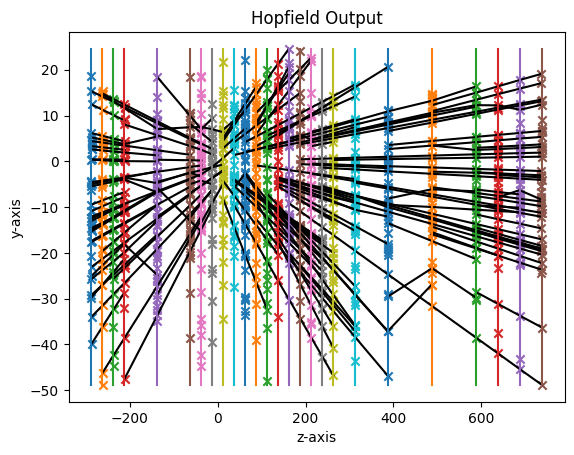

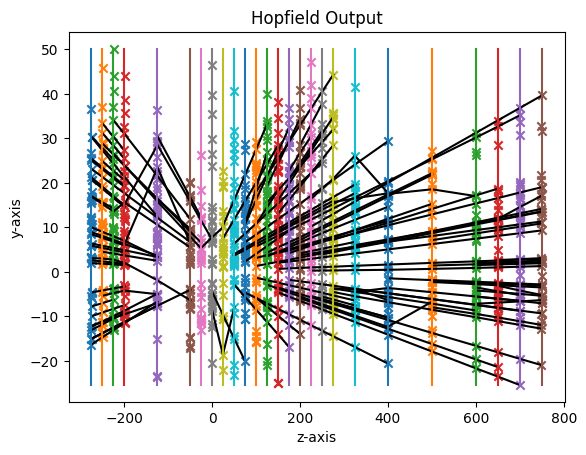

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_936

starting instance 2 out of 10

Number of max neurons: 7998
[INFO] Hopfield Networks initialized in 1 mins 23.66 seconds
energy: -995.4426330901479
energy: -910.7620783797896
energy: -1012.9860689961129
energy: -913.6401499146093
energy: -1058.4017846523482
energy: -898.5193231531365
energy: -992.3001457940617
energy: -749.2264580415775
energy: -945.2974308418486
energy: -794.0078713454166
[HOPFIELD] converged network by below_mean after 453 mins 40.46 seconds; (energy: -927.06)
energy: -1099.8008656585914
energy: -793.338020081787
energy: -944.5676532456633
energy: -869.8094897444201
energy: -825.6381805267329
energy: -1023.4841629904245
energy: -944.945586661802
energy: -1023.9656858929036
energy: -1103.3815341232798
energy: -1060.7794263360638
[HOPFIELD] converged network by below_mean after 544 mins 18.49 seconds; (energy: -968.97)
[INFO] tra

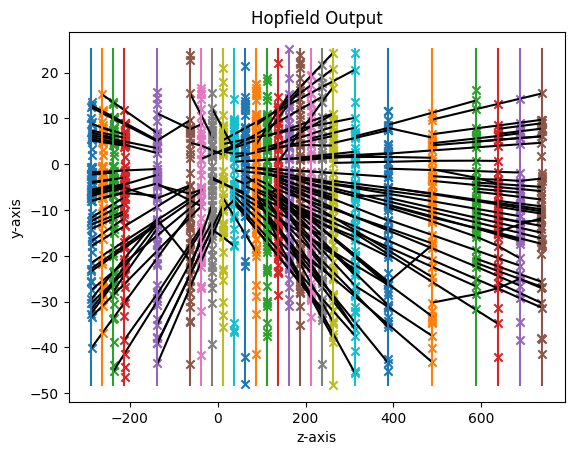

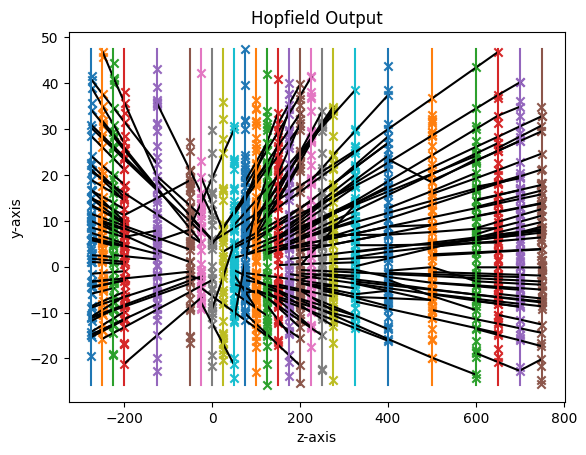

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_853

starting instance 3 out of 10

Number of max neurons: 484
[INFO] Hopfield Networks initialized in 0 mins 3.16 seconds
energy: -249.19012975069555
energy: -254.19592604570707
energy: -239.56166748179726
energy: -241.77201942001273
energy: -257.8243775597465
energy: -243.10162557235702
energy: -230.6803925726844
energy: -250.17595400005484
energy: -246.55020537393804
energy: -248.60111143843716
[HOPFIELD] converged network by below_mean after 0 mins 20.58 seconds; (energy: -246.17)
energy: -288.94195913202117
energy: -312.7480038524089
energy: -397.35282327068654
energy: -303.19257909550157
energy: -320.2962475195592
energy: -326.773013459071
energy: -300.81603913289655
energy: -292.0948440709589
energy: -383.94257908627094
energy: -375.33713740853864
[HOPFIELD] converged network by below_mean after 1 mins 31.22 seconds; (energy: -330.15)
[INFO] t

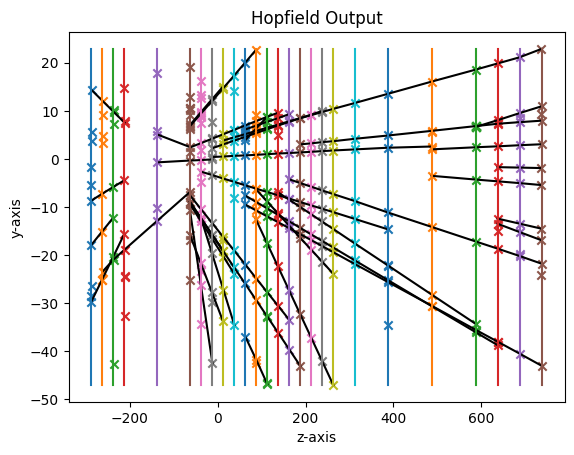

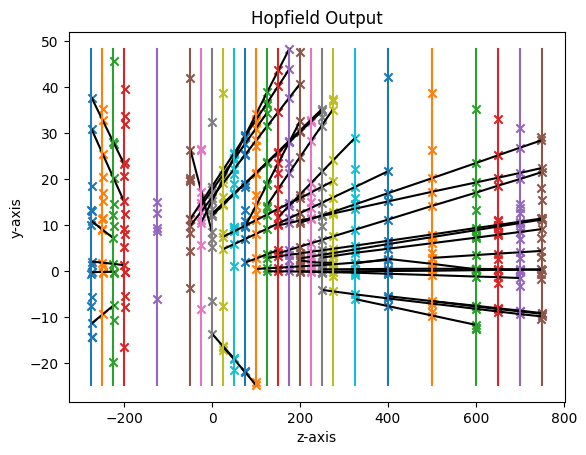

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_122

starting instance 4 out of 10

Number of max neurons: 4288
[INFO] Hopfield Networks initialized in 0 mins 12.20 seconds
energy: -542.9890670015405
energy: -537.3255359182111
energy: -386.27188483502556
energy: -459.83236492245555
energy: -450.0050140128292
energy: -415.95837835081994
energy: -411.81390892298754
energy: -384.1759941564667
energy: -427.9843577240749
energy: -430.58789558332904
[HOPFIELD] converged network by below_mean after 53 mins 59.28 seconds; (energy: -444.69)
energy: -521.0251719386273
energy: -540.0934740355488
energy: -551.1320541338359
energy: -543.2863571858225
energy: -548.8395278094692
energy: -505.73139731259903
energy: -505.0287778093965
energy: -578.4413583347745
energy: -526.617325698945
energy: -549.3283412999805
[HOPFIELD] converged network by below_mean after 19 mins 24.74 seconds; (energy: -536.95)
[INFO] track

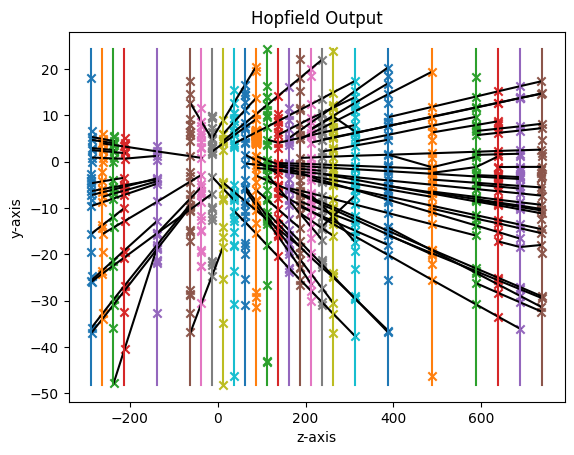

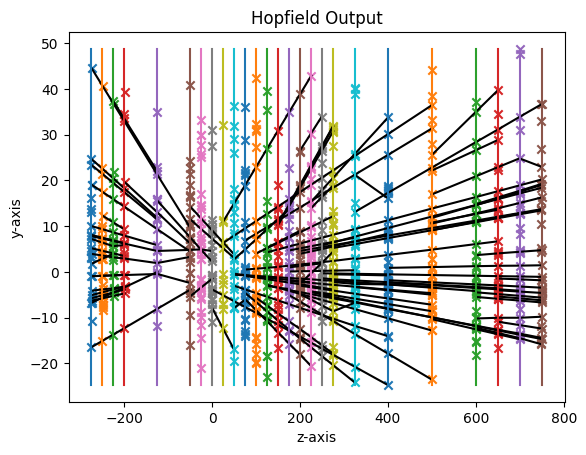

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_769

starting instance 5 out of 10

Number of max neurons: 1369
[INFO] Hopfield Networks initialized in 0 mins 5.38 seconds
energy: -365.03067581625254
energy: -394.37719879551736
energy: -376.12458986408313
energy: -420.85285032263477
energy: -401.05852272648804
energy: -361.96708992122126
energy: -340.78350589080895
energy: -426.2606249004311
energy: -401.15198864025496
energy: -521.488343330114
[HOPFIELD] converged network by below_mean after 6 mins 17.74 seconds; (energy: -400.91)
energy: -537.0631170959643
energy: -445.4819721127282
energy: -448.1393737702495
energy: -435.1045432124153
energy: -459.93232316584414
energy: -465.3045549934335
energy: -419.25638042339926
energy: -442.82318256758685
energy: -391.1137323742752
energy: -453.9546895225385
[HOPFIELD] converged network by below_mean after 7 mins 27.14 seconds; (energy: -449.82)
[INFO] tra

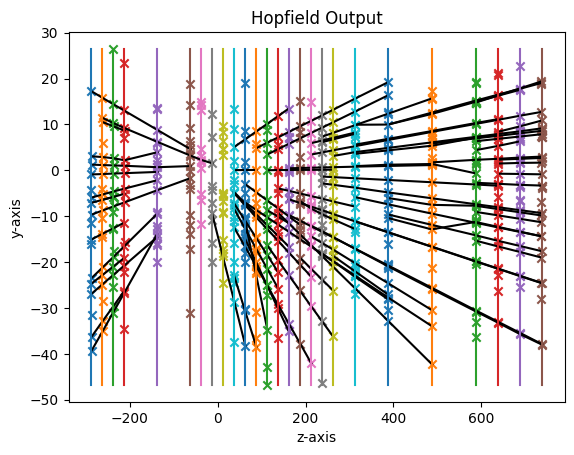

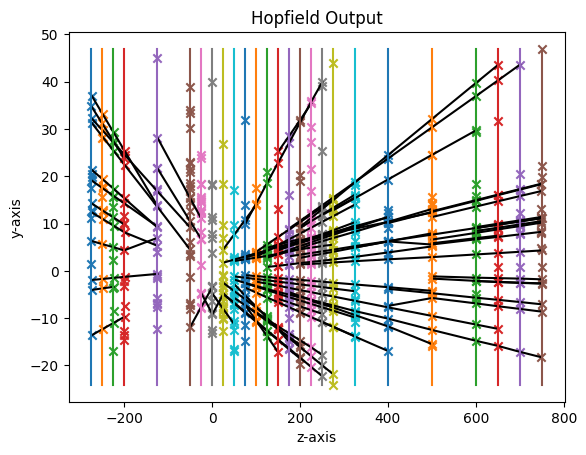

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_231

starting instance 6 out of 10

Number of max neurons: 930
[INFO] Hopfield Networks initialized in 0 mins 3.75 seconds
energy: -347.4978052121439
energy: -321.63005567262843
energy: -299.6004483257975
energy: -370.37878177640584
energy: -301.2641348449496
energy: -345.5449650150347
energy: -336.11368941197094
energy: -323.55236411764236
energy: -292.0906570015637
energy: -312.0954248075977
[HOPFIELD] converged network by below_mean after 3 mins 54.41 seconds; (energy: -324.98)
energy: -324.7506931811104
energy: -423.6554678568889
energy: -367.0478248491998
energy: -339.7474742266829
energy: -384.27952934786384
energy: -352.70591606093603
energy: -328.3368308972504
energy: -353.67262753932374
energy: -305.35218009334363
energy: -398.80416008320276
[HOPFIELD] converged network by below_mean after 3 mins 48.89 seconds; (energy: -357.84)
[INFO] track

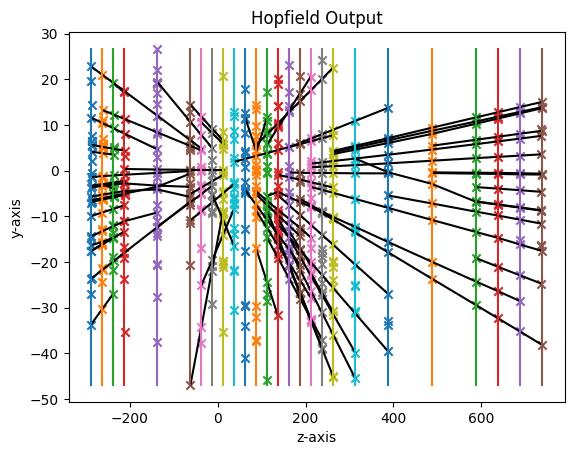

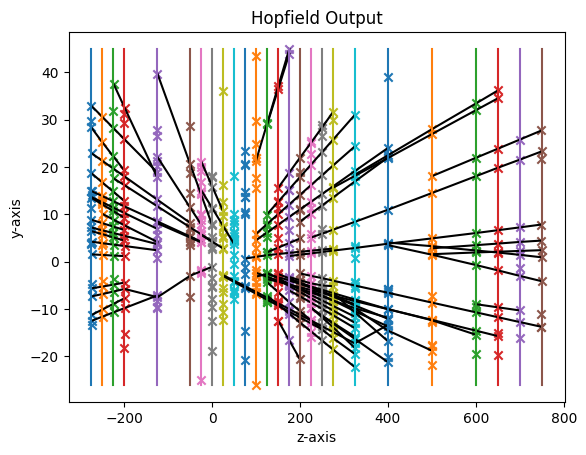

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_164

starting instance 7 out of 10

Number of max neurons: 2601
[INFO] Hopfield Networks initialized in 0 mins 15.15 seconds
energy: -535.2648347067345
energy: -520.4106414665919
energy: -502.9237567947813
energy: -488.53851888814904
energy: -451.1967098237636
energy: -513.8360753327077
energy: -540.4723134482862
energy: -458.12017758388254
energy: -531.5268624427196
energy: -492.96617232452894
[HOPFIELD] converged network by below_mean after 19 mins 12.88 seconds; (energy: -503.53)
energy: -565.8410661309445
energy: -499.3605093005638
energy: -596.9073248328501
energy: -548.9960317821682
energy: -556.6078285105334
energy: -558.9549595050803
energy: -575.7203978172755
energy: -517.0728631142815
energy: -576.1533405732081
energy: -581.6253242650278
[HOPFIELD] converged network by below_mean after 31 mins 32.47 seconds; (energy: -557.72)
[INFO] tracks 

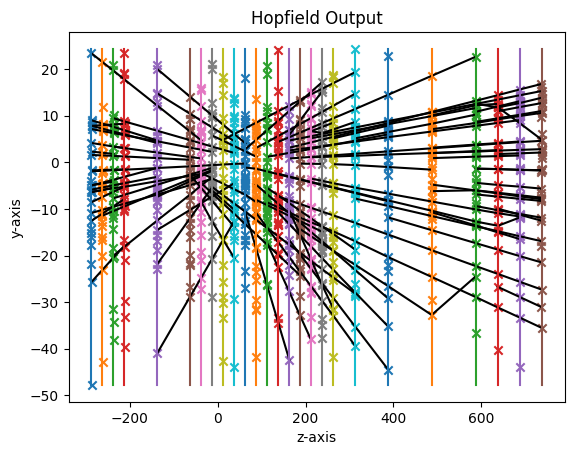

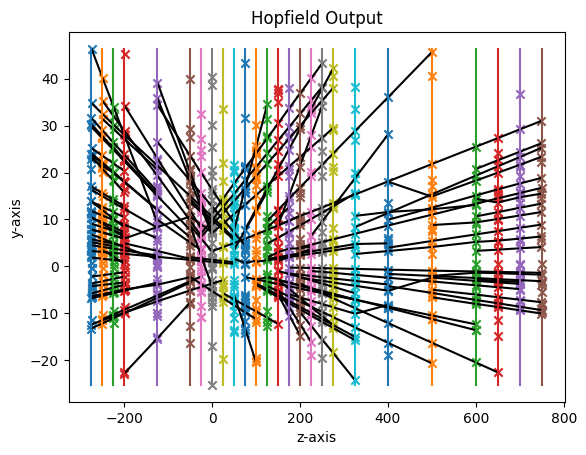

[INFO] Evaluate Event: c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/samples/minibias_deciles/velo_event_837

starting instance 8 out of 10

Number of max neurons: 5644
[INFO] Hopfield Networks initialized in 0 mins 45.92 seconds
energy: -928.5952522782239
energy: -854.6613763712514
energy: -839.811714818097
energy: -841.9884604377104
energy: -603.7011822348305
energy: -892.9212307288982
energy: -914.777310882771
energy: -794.3393524146587
energy: -798.0841205590024
energy: -768.2766315819383
[HOPFIELD] converged network by below_mean after 239 mins 38.34 seconds; (energy: -823.72)
energy: -628.2936187840947
energy: -687.6128028079856
energy: -687.6653689537068
energy: -694.8160569515776


In [14]:
###################################################################
save_experiment(
        "aurelie_experiments_11_02_deciles",
        "Test deciles minibias dataset",
        "Upgraded network - Best Configuration Test on 10 events from the deciles minibias datasets",
        parameters,
        "/datasets/samples/minibias_deciles/velo_event_",
        10,
    )

In [ ]:
save_experiment(
        "aurelie_experiments_11_02_deciles",
        "Test deciles bsphiphi dataset",
        "Upgraded network - Best Configuration Test on 10 events from the deciles bsphiphi datasets",
        parameters,
        "/datasets/samples/bsphiphi_deciles/velo_event_",
        10,
    )